# Satellite Imagery Regression using Attention-based Deep MIL

Date: 15/05/2025  

Aristotle University of Thessaloniki  

MSc in Artificial Intelligence

## Import Libraries

In [ ]:
!pip install pydot graphviz

In [ ]:
import numpy as np
import pickle
import keras
from keras import layers, ops
from tqdm import tqdm
from matplotlib import pyplot as plt
import gdown
import requests
import os
import yaml
import random
import matplotlib
from scipy.stats import chi2_contingency
import tensorflow as tf
import matplotlib.cm as cm
from tensorflow.keras.applications.xception import Xception
# Set the seed for random function of python
random.seed(1)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
from scipy.stats import pearsonr

## Unzip Bags dataset

First of all, we need to collect the dataset containing the night-time images from the VIIRS satellite images. In this experiment the bagsAugmented variant will be used, which contains the images augmented with various techniques such as random rotation, flip, etc.

In [ ]:
# unzip fetched dataset (need to mount Drive)
!unzip -q /content/drive/MyDrive/VIIRS/bagsAugmented.zip -d /content/

## Collect GDB statistics

The second step, is about collecting the labels that will be used in this experiment. The Gross domestic product (GDP) will be used as found in Eurostat.
The GDP score for each country was collected per year.

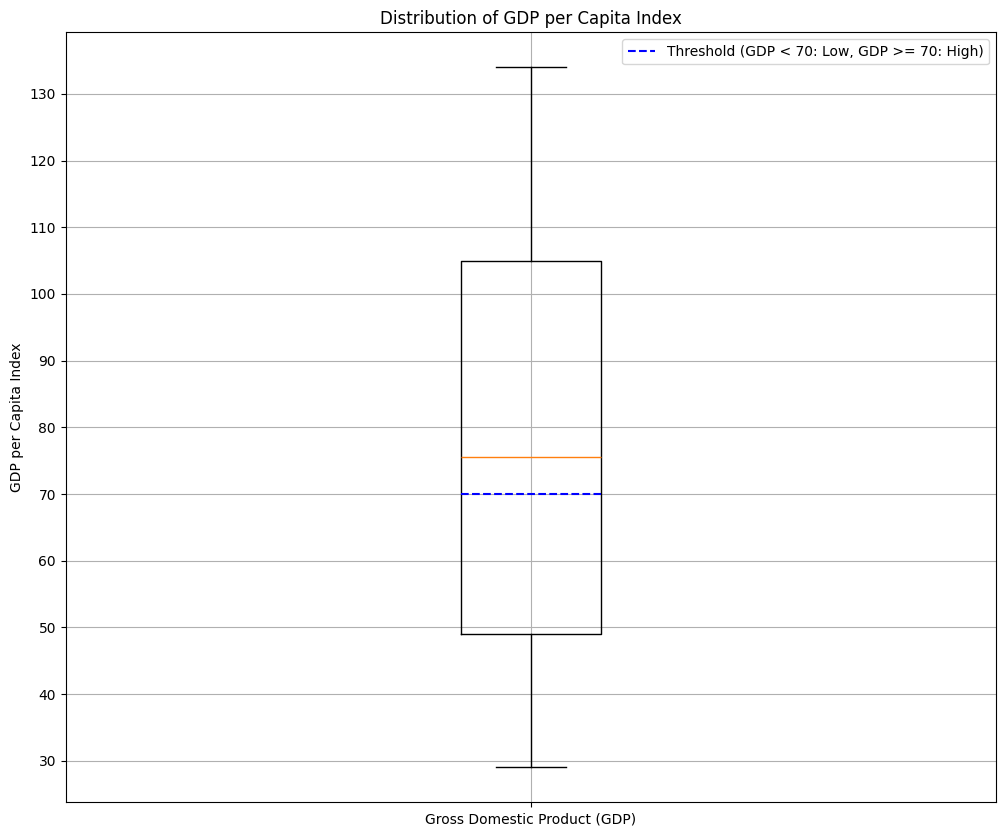

In [ ]:
# download y labels yaml file from github
url = "https://raw.githubusercontent.com/pleleGit/SatSenseAI/main/statistics/gdp.yaml"
response = requests.get(url)

with open("gdb.yaml", "wb") as f:
    f.write(response.content)

with open("gdb.yaml", "r") as f:
    gdb = yaml.safe_load(f)
gdb = gdb["gdp_per_capita_index"]

# collect all values of gdb and create a box plot
plt.figure(figsize=(12, 10))
scores = []
for key in gdb.keys():
    scores.append(gdb[key])
scores = np.array(scores).flatten()
plt.boxplot(scores)
plt.yticks(range(20, 160, 10))
plt.grid()
plt.title("Distribution of GDP per Capita Index") # Add title
plt.ylabel("GDP per Capita Index") # Add y-axis label
plt.xticks([1], ['Gross Domestic Product (GDP)']) # Add x-axis label

# Add a horizontal line at y=70 denoting the threshold
plt.hlines(y=70, xmin=0.925, xmax=1.075, color='b', linestyle='--', label='Threshold (GDP < 70: Low, GDP >= 70: High)')
plt.legend() # Add a legend to show the label for the threshold line

plt.show()

## Create & Import Bags

This section focuses on loading and organizing the satellite imagery dataset for training an **Attention-based Deep Multiple Instance Learning (MIL)** model. It starts by importing the GDP labels from a YAML file, which will be used as the **target variable**. Then, it iterates through the dataset, which is structured by country and year. For each country and year, it randomly selects a fixed number of image instances (40) to form a "bag". These bags are then assigned to training, validation, or test sets based on the country and year. The bags and their corresponding GDP labels are stored in separate lists for each dataset split (train, validation, test). Finally, it prints statistics about the created datasets, including the number of bags, instances per bag, instance shape, and label shape. This organized data is then ready to be used for training the MIL model in subsequent steps.

In [ ]:
# load custom Bags dataset for training with Keras
train_bags = []
val_bags = []
test_bags = []
dataset_path = "/content/bagsAugmented"
instances_count = 40
train_bags_labels = []
val_bags_labels = []
test_bags_labels = []
test_bags_names = []
countries = sorted(os.listdir(dataset_path))
years = sorted(os.listdir(os.path.join(dataset_path, countries[0])))
print(f"Countries: {countries}")
print(f"Bags per year: {years}")
train_countries = random.sample(countries, 12)
for i, country in enumerate(countries):
    val_year = random.sample(years, 2)
    for year_bag in years:
        bag = []
        # Get the list of files
        all_files = os.listdir(os.path.join(dataset_path, country, year_bag))
        # Pick 30 random files without replacement
        selected_files = random.sample(all_files, instances_count)
        for img_path in selected_files:
            # Loads each image into PIL format
            img = keras.preprocessing.image.load_img(os.path.join(dataset_path, country, year_bag, img_path),
                                                    target_size=(300, 225),
                                                    color_mode="grayscale")
            # Converts a PIL Image instance to a NumPy array
            img_array = keras.preprocessing.image.img_to_array(img)
            img_array = img_array / 255.0  # standardize image to [0, 1]
            bag.append(img_array)
            if len(bag) == instances_count:
                break
        # collect the corresponding gdp per capita index
        id = int(year_bag[1:]) - 14
        if country in train_countries:
            if year_bag in val_year:
                val_bags.append(bag)
                val_bags_labels.append([gdb[country][id]])
            else:
                train_bags.append(bag)
                train_bags_labels.append([gdb[country][id]])
        else:
            test_bags.append(bag)
            test_bags_labels.append([gdb[country][id]])
            test_bags_names.append(f"{country}_{year_bag[1:]}")
train_bags = np.squeeze(np.swapaxes(np.array(train_bags), 0, 1))
train_bags_labels = np.array(train_bags_labels)
val_bags = np.squeeze(np.swapaxes(np.array(val_bags), 0, 1))
val_bags_labels = np.array(val_bags_labels)
test_bags = np.squeeze(np.swapaxes(np.array(test_bags), 0, 1))
test_bags_labels = np.array(test_bags_labels)

Countries: ['Albania', 'Austria', 'Belgium', 'Bosnia', 'Bulgaria', 'England', 'FYROM', 'France', 'Germany', 'Greece', 'Hungary', 'Italy', 'Montenegro', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Serbia', 'Spain']
Bags per year: ['b14', 'b15', 'b16', 'b17', 'b18', 'b19', 'b20', 'b21', 'b22', 'b23']


In [ ]:
print("~~~~~~~~~~~ Stats for training set: ~~~~~~~~~~~")
print(f"Bags Shape: {train_bags.shape}")
print(f"Number of Bags: {train_bags.shape[1]}")
print(f"Number of Instances per Bag: {train_bags.shape[0]}")
print(f"Shape of each Instance: {train_bags.shape[2:]}")
print(f"Shape of Labels: {train_bags_labels.shape}")
print("~~~~~~~~~~~ Stats for validation set: ~~~~~~~~~~~")
print(f"Bags Shape: {val_bags.shape}")
print(f"Number of Bags: {val_bags.shape[1]}")
print(f"Number of Instances per Bag: {val_bags.shape[0]}")
print(f"Shape of each Instance: {val_bags.shape[2:]}")
print(f"Shape of Labels: {val_bags_labels.shape}")
print("~~~~~~~~~~~ Stats for test set: ~~~~~~~~~~~")
print(f"Bags Shape: {test_bags.shape}")
print(f"Number of Bags: {test_bags.shape[1]}")
print(f"Number of Instances per Bag: {test_bags.shape[0]}")
print(f"Shape of each Instance: {test_bags.shape[2:]}")
print(f"Shape of Labels: {test_bags_labels.shape}")
train_bags = list(train_bags)
val_bags = list(val_bags)
test_bags = list(test_bags)

~~~~~~~~~~~ Stats for training set: ~~~~~~~~~~~
Bags Shape: (40, 96, 300, 225)
Number of Bags: 96
Number of Instances per Bag: 40
Shape of each Instance: (300, 225)
Shape of Labels: (96, 1)
~~~~~~~~~~~ Stats for validation set: ~~~~~~~~~~~
Bags Shape: (40, 24, 300, 225)
Number of Bags: 24
Number of Instances per Bag: 40
Shape of each Instance: (300, 225)
Shape of Labels: (24, 1)
~~~~~~~~~~~ Stats for test set: ~~~~~~~~~~~
Bags Shape: (40, 70, 300, 225)
Number of Bags: 70
Number of Instances per Bag: 40
Shape of each Instance: (300, 225)
Shape of Labels: (70, 1)


## Prepare the MIL Attention layer

In this section a custom Keras layer called MILAttentionLayer is defined, which is crucial for implementing the attention mechanism in the Multiple Instance Learning (MIL) model. This layer is designed to **learn and assign attention weights to individual instances within a bag**, allowing the model to focus on the most relevant instances for prediction. The MILAttentionLayer incorporates a gated mechanism that enhances the learning of non-linear relationships between instances and their corresponding bag labels. By computing attention scores and applying softmax normalization, the layer ensures that **the attention weights sum up to 1**, effectively highlighting the importance of each instance in the bag. This attention mechanism is a key component of the MIL model, enabling it to effectively handle bags of instances and make accurate predictions based on the **most informative instances within each bag**.

In [ ]:
class MILAttentionLayer(layers.Layer):
    def __init__(self, weight_dim, kernel_init="glorot_uniform", kernel_reg="None", use_gated=False, **kwargs):
        super().__init__(**kwargs)
        self.weight_dim = weight_dim  # dimension of the weight matrix
        self.use_gated = use_gated  # to enable/disable gated mechanism
        self.kernel_init = keras.initializers.get(kernel_init)
        self.kernel_reg = keras.regularizers.get(kernel_reg)

        self.v_init = self.kernel_init
        self.w_init = self.kernel_init
        self.u_init = self.kernel_init

        self.v_reg = self.kernel_reg
        self.w_reg = self.kernel_reg
        self.u_reg = self.kernel_reg

    def build(self, input_shape):
        # Input shape.
        # List of 2D tensors with shape: (batch_size, input_dim).
        input_dim = input_shape[0][1]
        self.v_weight_params = self.add_weight(
            shape=(input_dim, self.weight_dim),
            initializer=self.v_init,
            name="v",
            regularizer=self.v_reg,
            trainable=True,
        )
        self.w_weight_params = self.add_weight(
            shape=(self.weight_dim, 1),
            initializer=self.w_init,
            name="w",
            regularizer=self.w_reg,
            trainable=True,
        )
        if self.use_gated:
            self.u_weight_params = self.add_weight(
                shape=(input_dim, self.weight_dim),
                initializer=self.u_init,
                name="u",
                regularizer=self.u_reg,
                trainable=True,
            )
        else:
            self.u_weight_params = None
        self.input_built = True

    def call(self, inputs):
        # Assigning variables from the number of inputs.
        instances = [self.compute_attention_scores(instance) for instance in inputs]
        # Stack instances into a single tensor.
        instances = ops.stack(instances)
        # Apply softmax over instances such that the output summation is equal to 1.
        alpha = ops.softmax(instances, axis=0)
        # Split to recreate the same array of tensors we had as inputs.
        return [alpha[i] for i in range(alpha.shape[0])]

    def compute_attention_scores(self, instance):
        # Reserve in-case "gated mechanism" used.
        original_instance = instance
        # tanh(v*h_k^T)
        instance = ops.tanh(ops.tensordot(instance, self.v_weight_params, axes=1))
        # for learning non-linear relations efficiently.
        if self.use_gated:
            instance = instance * ops.sigmoid(
                ops.tensordot(original_instance, self.u_weight_params, axes=1)
            )
        # w^T*(tanh(v*h_k^T)) / w^T*(tanh(v*h_k^T)*sigmoid(u*h_k^T))
        return ops.tensordot(instance, self.w_weight_params, axes=1)

## Create the Attention-based Deep MIL Model

This section defines the architecture of the Attention-based Deep MIL model. The model first **applies data augmentation layers** to each input instance. Then, it **extracts features from each augmented instance using a pre-trained Xception model** (with frozen layers) followed by global average pooling and two dense layers. It then **applies the MILAttentionLayer** to calculate attention weights for each instance, allowing the model to **focus on the most relevant** ones. These attention weights are multiplied with the corresponding instance embeddings and concatenated to form a single representation for the entire bag. Finally, a dense layer with 1 unit and linear activation is used to predict the final score of GDP. This architecture enables the model to learn effectively from bags of instances by selectively attending to the most informative ones, leading to improved performance in MIL tasks.

In [ ]:
def create_model(instance_shape, instances_count):
    # Extract features from inputs.
    inputs, embeddings = [], []
    extended_shape = (instance_shape[0], instance_shape[1], 3)
    base_model = Xception(
        weights="imagenet",
        include_top=False,
        input_shape=extended_shape,
    )
    # freeze all layers of Xception
    for layer in base_model.layers:
        layer.trainable = False
    dense_layer_1 = layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.L2(0.01))
    dense_layer_2 = layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.L2(0.01))
    # rand_rot = tf.keras.layers.RandomRotation(factor=2/36, fill_mode="constant", fill_value=0.0, seed=42)
    rand_flip = tf.keras.layers.RandomFlip("horizontal_and_vertical", seed=42)
    for _ in range(instances_count):
        inp = layers.Input(instance_shape)
        # Data Augmentation Layers
        # augmented_inp = rand_rot(inp)
        augmented_inp = rand_flip(inp)
        # convert to 3-channel input (for compatibility with Xception)
        inp_ext = layers.Lambda(lambda x: tf.concat([tf.expand_dims(x, axis=-1)] * 3, axis=-1))(augmented_inp)
        embed = base_model(inp_ext)
        pool = keras.layers.GlobalAveragePooling2D()(embed)
        dense_1 = dense_layer_1(pool)
        dense_2 = dense_layer_2(dense_1)
        inputs.append(inp)
        embeddings.append(dense_2)
    # Invoke the attention layer.
    alpha = MILAttentionLayer(
        weight_dim=256,
        kernel_reg=keras.regularizers.L2(0.01),
        use_gated=True,
        name="alpha",
    )(embeddings)
    # Multiply attention weights with the input layers.
    multiply_layers = [
        layers.multiply([alpha[i], embeddings[i]]) for i in range(len(alpha))
    ]
    # Concatenate layers.
    concat = layers.concatenate(multiply_layers, axis=1)
    # Regression output node.
    output = layers.Dense(1, activation="linear")(concat)
    return keras.Model(inputs, output)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


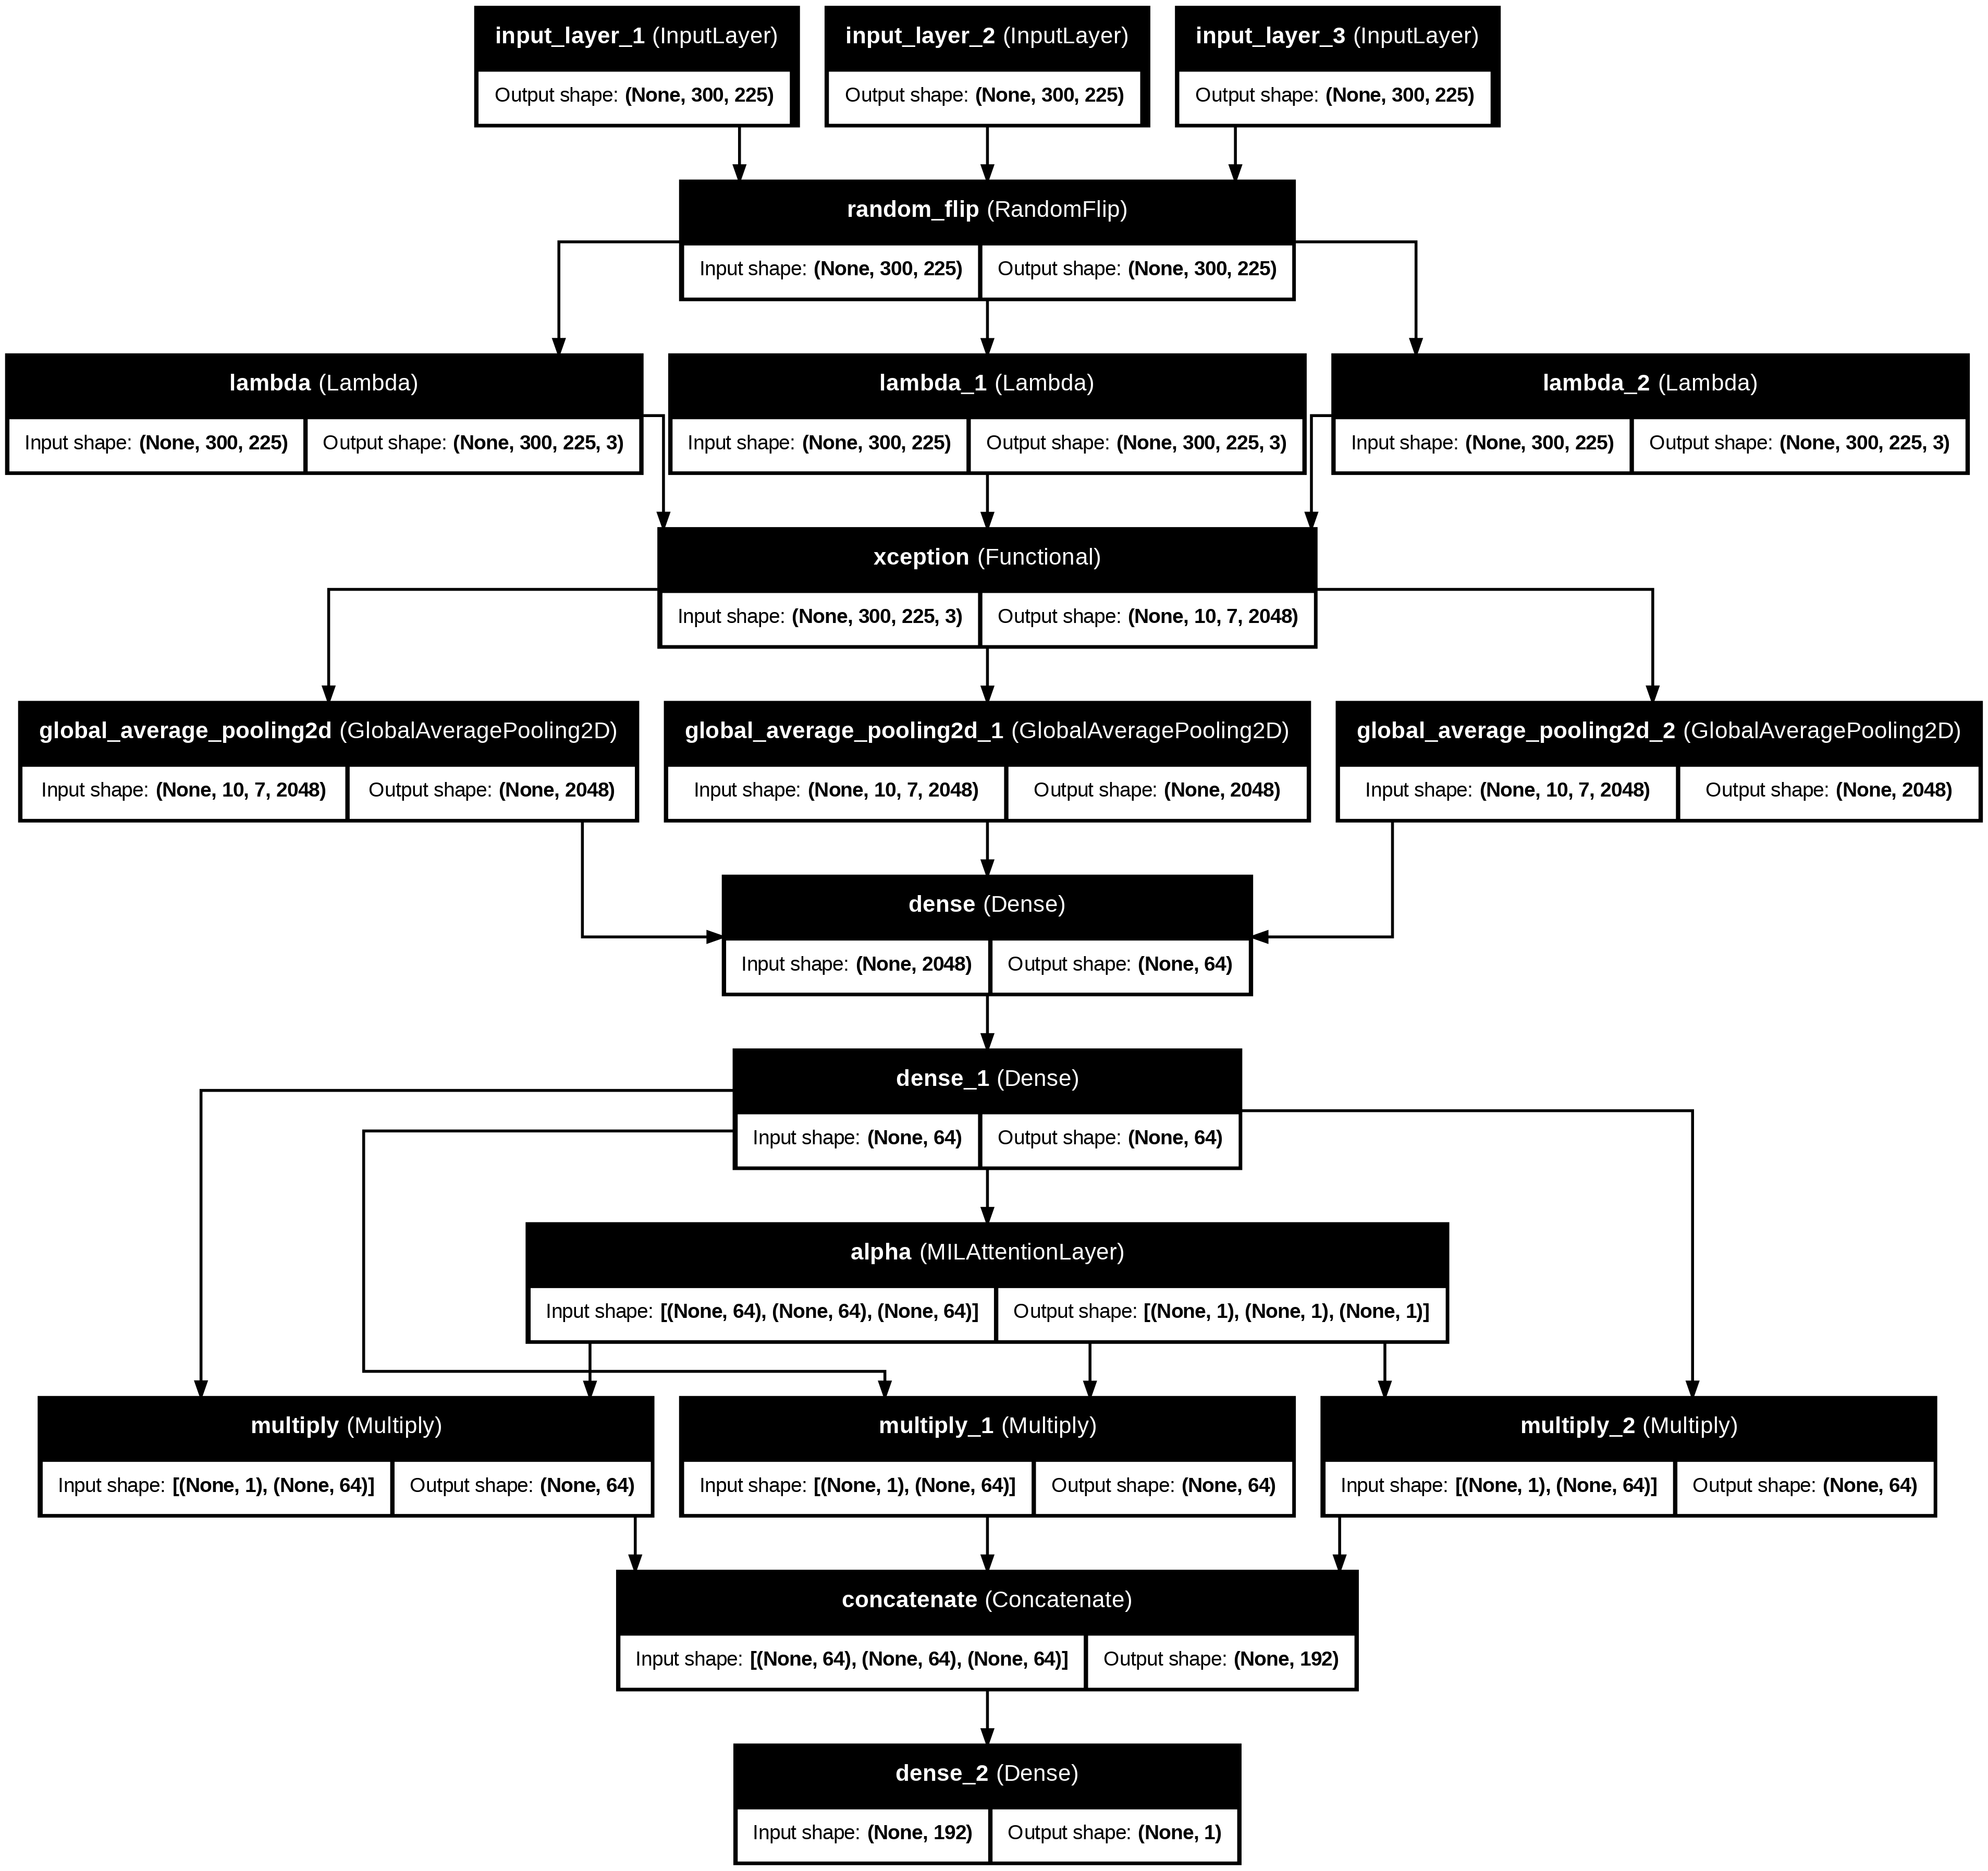

In [ ]:
model = create_model(train_bags[0][0].shape, 3)  # use only 3 instances for visualisation purposes
keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Build and Train the Attention-based Deep MIL Model

This section focuses on building and training the Attention-based Deep MIL model using the architecture defined in the previous section.  

Model checkpoints, early stopping, and learning rate scheduling techniques are employed to facilitate efficient training and prevent overfitting.  

The plot_learning_curves function is used to visualize the training progress by plotting the training and validation loss/accuracy curves over epochs. This visualization aids in assessing model convergence, overfitting, and the overall performance of the model during training.

Based on the generated learning curves, we can observe that the model generally converges well, showing decreasing loss and increasing accuracy on both the training and validation sets. This indicates that the model is learning effectively from the data.

In [ ]:
def plot_learning_curves(history, model_idx=0):
    """Plot training and validation loss/accuracy."""
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    # Loss plot
    axs[0].plot(history.history["loss"], label="Train Loss")
    axs[0].plot(history.history["val_loss"], label="Val Loss")
    axs[0].set_title(f"Model {model_idx} - Loss")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid()
    # Accuracy plot
    axs[1].plot(history.history["accuracy"], label="Train Accuracy")
    axs[1].plot(history.history["val_accuracy"], label="Val Accuracy")
    axs[1].set_title(f"Model {model_idx} - Accuracy")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()
    axs[1].grid()
    plt.show()

In [ ]:
def train(train_data, train_labels, val_data, val_labels, model, model_idx=0):
    """Train a model with callbacks, better logging, and plots."""

    # Create a clean temp folder
    os.makedirs("/tmp", exist_ok=True)
    file_path = f"/tmp/best_model_{model_idx}.weights.h5"

    # Callbacks
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            file_path,
            monitor="val_loss",
            verbose=1,
            mode="min",
            save_best_only=True,
            save_weights_only=True,
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=10,
            restore_best_weights=True,
            verbose=1,
            mode="min",
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=3,
            verbose=1,
            mode="min",
            min_lr=1e-6,
        )
    ]
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="mean_absolute_error",
        metrics=["mean_absolute_error"],
    )
    # Train model
    history = model.fit(
        train_data,
        train_labels,
        validation_data=(val_data, val_labels),
        epochs=80,
        batch_size=8,
        callbacks=callbacks,
        verbose=1,
    )
    # Load best weights
    model.load_weights(file_path)
    # Plot learning curves
    plot_learning_curves(history, model_idx=model_idx)
    return model

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 88.0253 - mean_absolute_error: 84.3577
Epoch 1: val_loss improved from inf to 85.04633, saving model to /tmp/best_model_0.weights.h5
12/12 ━━━━━━━━━━━━━━━━━━━━ 370s 12s/step - loss: 87.9108 - mean_absolute_error: 84.2652 - val_loss: 85.0463 - val_mean_absolute_error: 82.2737 - learning_rate: 0.0010
Epoch 2/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 89.2689 - mean_absolute_error: 86.6835
Epoch 2: val_loss improved from 85.04633 to 81.77036, saving model to /tmp/best_model_0.weights.h5
12/12 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - loss: 88.8992 - mean_absolute_error: 86.3264 - val_loss: 81.7704 - val_mean_absolute_error: 79.6673 - learning_rate: 0.0010
Epoch 3/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 78.8528 - mean_absolute_error: 76.8120
Epoch 3: val_loss improved from 81.77036 to 70.59390, saving model to /tmp/best_model_0.weights.h5
12/12 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - loss: 78.8065 - mean_absolute_error: 76.7688 - 

KeyError: 'accuracy'

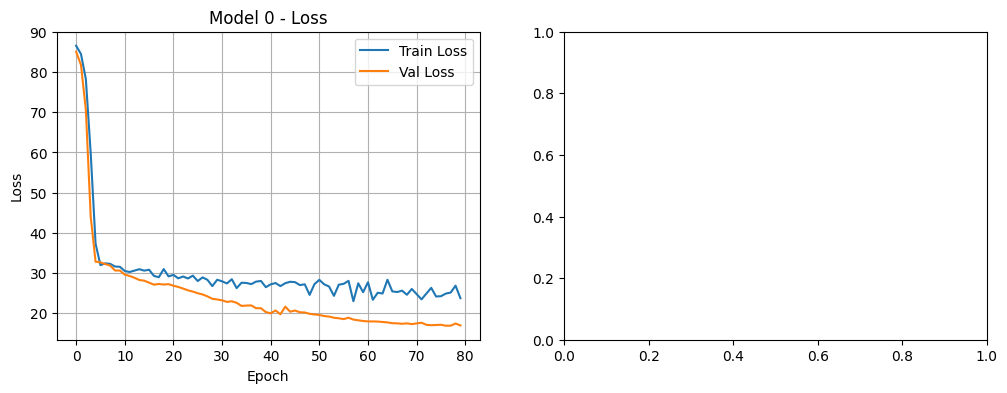

In [ ]:
ENSEMBLE_COUNT = 1
instance_shape = train_bags[0][0].shape
models = [create_model(instance_shape, instances_count) for _ in range(ENSEMBLE_COUNT)]

trained_models = [
    train(train_bags, train_bags_labels, val_bags, val_bags_labels, model, idx)
    for idx, model in enumerate(tqdm(models))
]

## Evaluate Trained Model

In [ ]:
batch_size = 8
test_predictions = []
num_test_bags = test_bags[0].shape[0]
test_bags_reshaped = [[test_bags[j][i] for j in range(len(test_bags))] for i in range(num_test_bags)]
print("Making predictions on the test set...")
for i in range(0, len(test_bags_reshaped), batch_size):
    batch_data = test_bags_reshaped[i:i+batch_size]
    batch_data_model_format = [np.stack([bag[j] for bag in batch_data]) for j in range(len(batch_data[0]))]
    batch_predictions = trained_models[0].predict(batch_data_model_format)
    test_predictions.append(batch_predictions)
test_predictions = np.concatenate(test_predictions, axis=0)

# Ensure predictions and labels have the same shape (should be (num_samples, 1))
test_predictions = test_predictions.flatten() # flatten if needed
test_bags_labels = test_bags_labels.flatten() # flatten if needed

In [ ]:
mae = mean_absolute_error(test_bags_labels, test_predictions)
mse = mean_squared_error(test_bags_labels, test_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test_bags_labels, test_predictions)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

Mean Absolute Error (MAE): 9.6684
Mean Squared Error (MSE): 140.8450
Root Mean Squared Error (RMSE): 11.8678
R-squared (R2): 0.7914


Based on the provided metrics, the trained model exhibits a high level of performance in predicting the GDP per Capita Index. The Mean Absolute Error (MAE) of 9.6684 indicates that, on average, your model's predictions are off by about 9.67 units from the actual GDP values. The Mean Squared Error (MSE) of 140.8450 and the Root Mean Squared Error (RMSE) of 11.8678 provide a measure of the average magnitude of the errors, with RMSE being in the same units as the target variable, suggesting typical prediction errors around 11.87 units.   Finally, the R-squared value of 0.7914 indicates that approximately 79.14% of the variance in the actual GDP per Capita Index can be explained by your model's predictions. Collectively, these metrics suggest that the model is capable of explaining a significant portion of the variability in the data and provides predictions that are, on average, within a reasonable range of the true values.

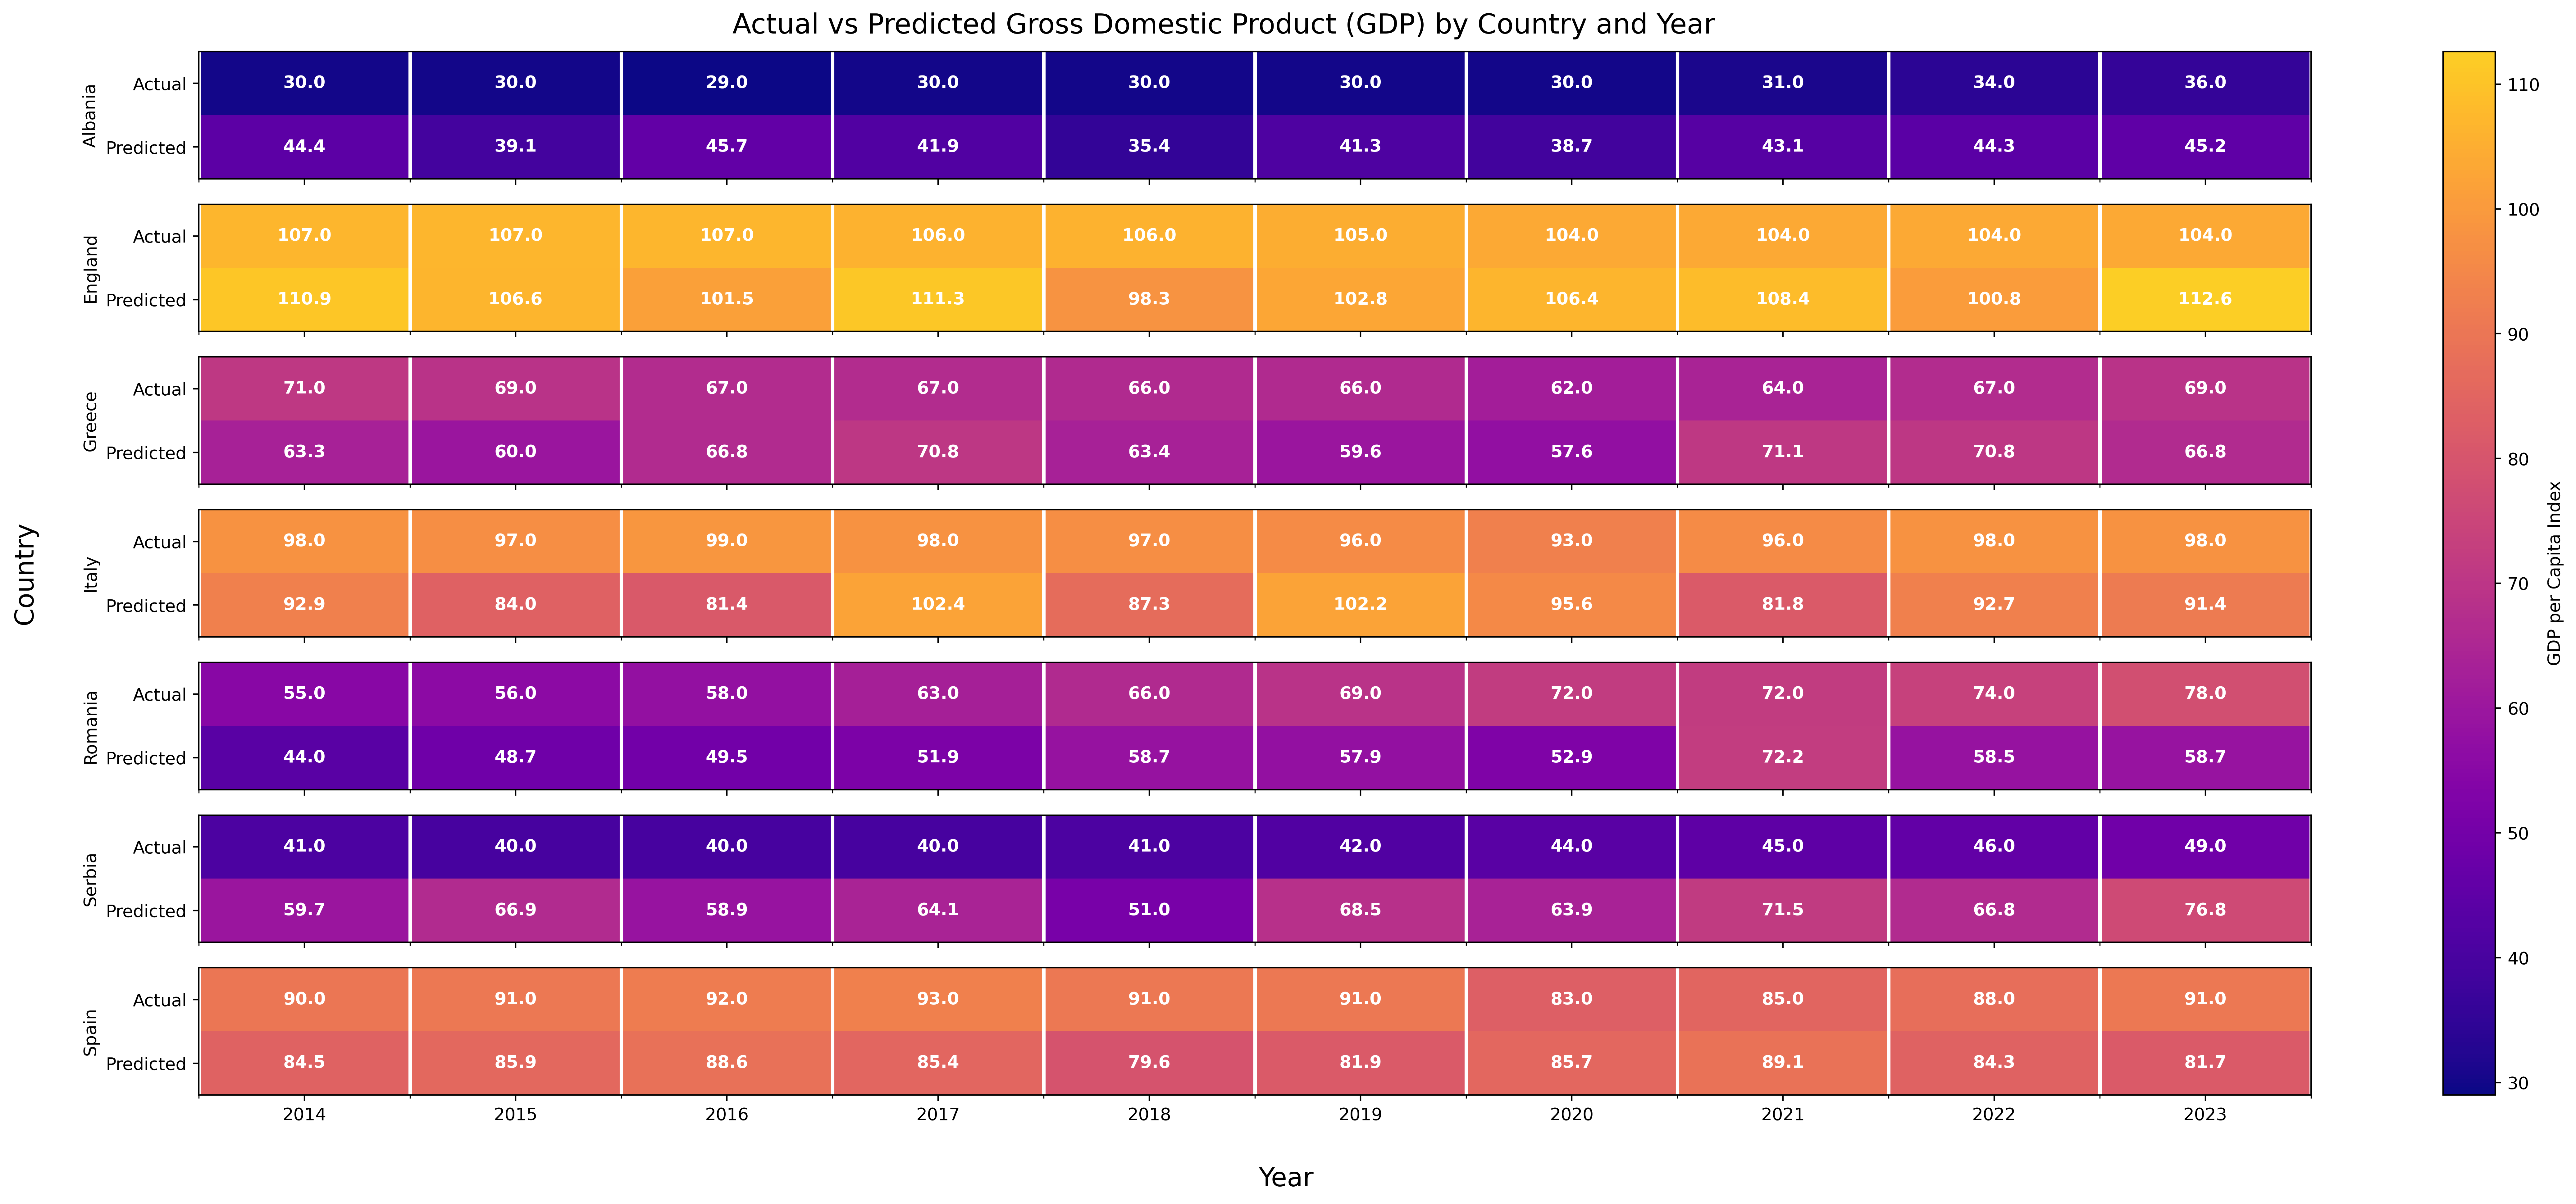

In [ ]:
# Assume test_bags_names, test_bags_labels, and test_predictions are available from previous cells

countries = [name.split('_')[0] for name in test_bags_names]
years = [2000 + int(name.split('_')[1]) for name in test_bags_names]

df_actual = pd.DataFrame({'country': countries, 'year': years, 'label': test_bags_labels.flatten()})
df_predicted = pd.DataFrame({'country': countries, 'year': years, 'label': test_predictions.flatten()}) # Use test_predictions for regression

pivot_actual = df_actual.pivot(index='country', columns='year', values='label')
pivot_predicted = df_predicted.pivot(index='country', columns='year', values='label')

# Get unique countries and years
unique_countries = pivot_actual.index
unique_years = pivot_actual.columns

fig, axes = plt.subplots(len(unique_countries), 1, figsize=(25, len(unique_countries) * 1.5),
                         gridspec_kw={'right': 0.9, 'left': 0.05, 'top': 0.95, 'bottom': 0.15}, dpi=400)

if len(unique_countries) == 1:
    axes = [axes]

x_tick_positions = np.arange(-0.5, len(unique_years), 1)

# Determine the global min and max values across all actual and predicted data for consistent coloring
global_vmin = min(pivot_actual.min().min(), pivot_predicted.min().min())
global_vmax = max(pivot_actual.max().max(), pivot_predicted.max().max())

plasma = matplotlib.colormaps["plasma"]
truncated_plasma = matplotlib.colors.LinearSegmentedColormap.from_list(
    'truncated_plasma',
    plasma(np.linspace(0, 0.9, 256))
)

for i, country in enumerate(unique_countries):
    ax = axes[i]
    combined_data = np.vstack([pivot_actual.loc[[country]], pivot_predicted.loc[[country]]])

    # Use the global vmin and vmax for consistent coloring across all subplots
    im = ax.imshow(combined_data, cmap=truncated_plasma, aspect='auto', vmin=global_vmin, vmax=global_vmax, interpolation='none')

    ax.set_ylabel(country)
    ax.set_yticks([0, 1]) # Set y-ticks for Actual and Predicted rows
    ax.set_yticklabels(['Actual', 'Predicted'])

    # Set x-ticks to be the years
    ax.set_xticks(np.arange(len(unique_years)))

    # Show x-tick labels (years) only on the last subplot
    if i == len(unique_countries) - 1:
        ax.set_xticklabels(unique_years)
    else:
        ax.set_xticklabels([])

    # Add grid lines
    ax.set_xticks(x_tick_positions, minor=True)
    ax.grid(which='minor', axis='x', color='white', linestyle='-', linewidth=2)

    # Add text annotations for actual and predicted values in each box
    for j, year in enumerate(unique_years):
        actual_value = pivot_actual.loc[country, year]
        predicted_value = pivot_predicted.loc[country, year]

        # Display actual value in the top row
        ax.text(j, 0, f'{actual_value:.1f}', ha='center', va='center', color='white', fontsize=10, weight='bold')

        # Display predicted value in the bottom row
        ax.text(j, 1, f'{predicted_value:.1f}', ha='center', va='center', color='white', fontsize=10, weight='bold')


# Add a colorbar for the overall plot
fig.colorbar(im, ax=axes.ravel().tolist(), label='GDP per Capita Index')

# Add a main title to the figure
fig.suptitle('Actual vs Predicted Gross Domestic Product (GDP) by Country and Year', fontsize=16, x=0.38, y=0.98)
# Add common xlabel and ylabel
fig.text(0.4, 0.08, 'Year', ha='center', fontsize=15)
fig.text(-0.01, 0.55, 'Country', va='center', rotation='vertical', fontsize=15)
plt.show()

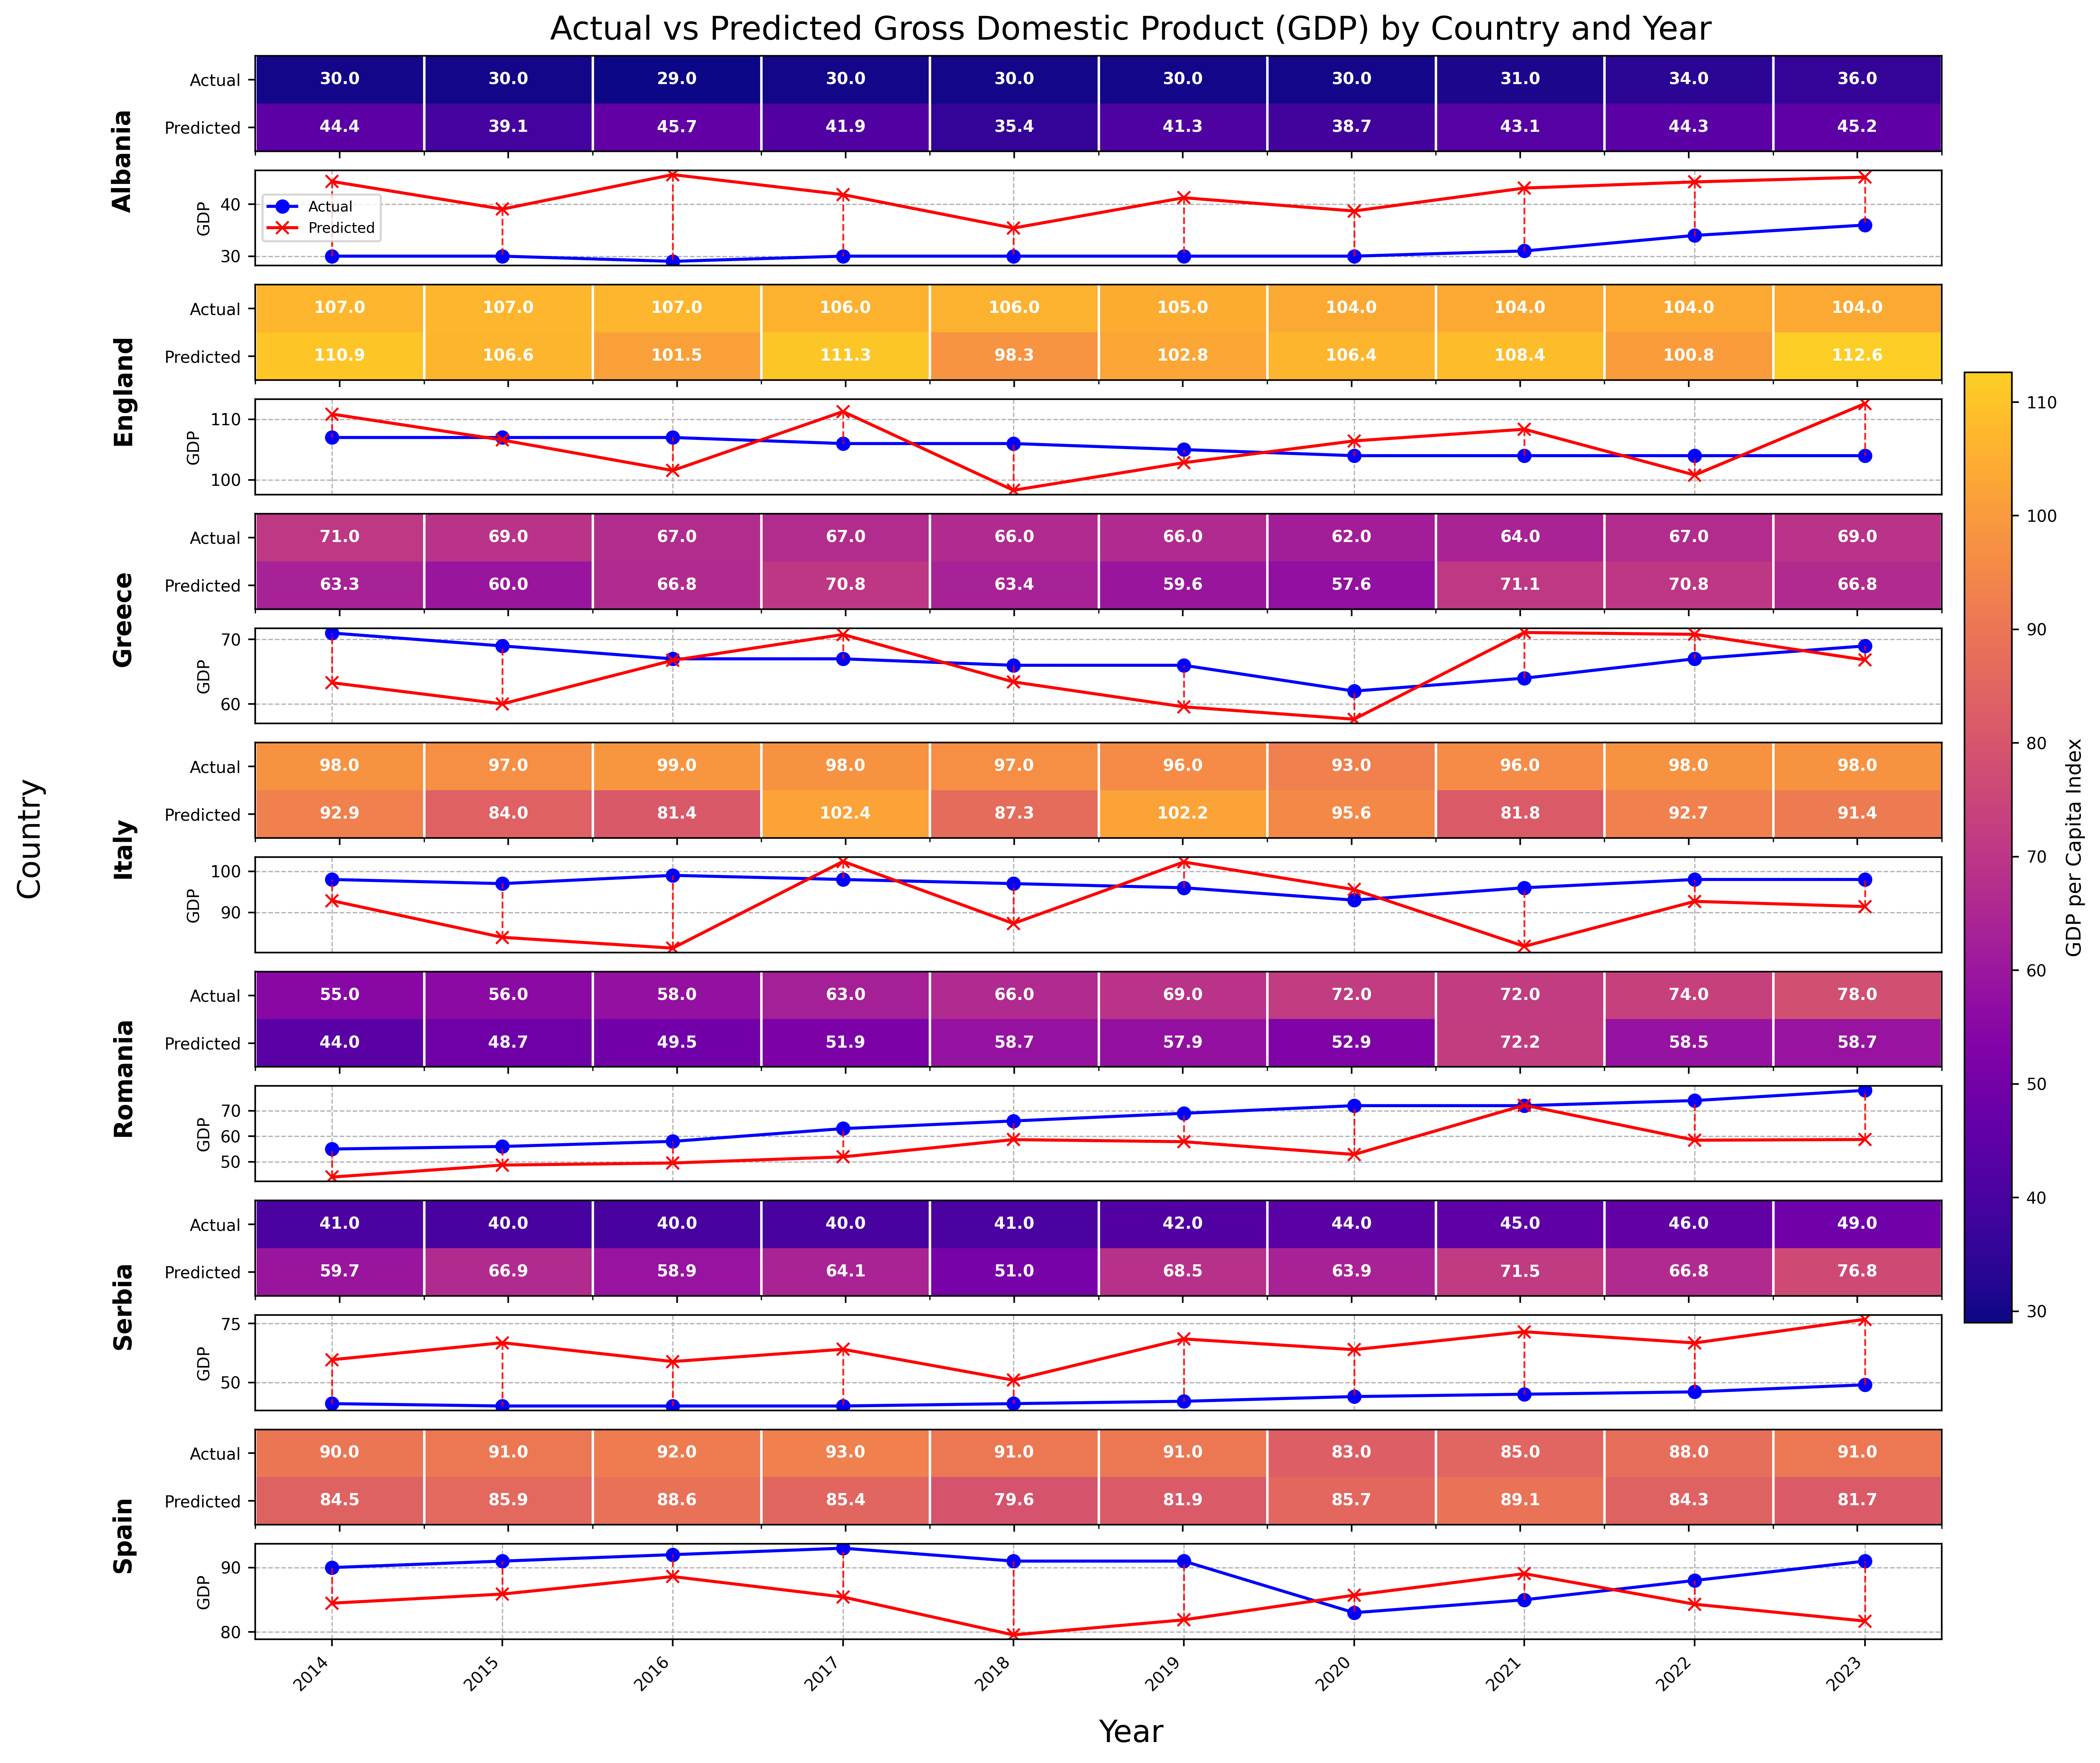

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches


# Prepare data
countries = [name.split('_')[0] for name in test_bags_names]
years = [2000 + int(name.split('_')[1]) for name in test_bags_names]

df_actual = pd.DataFrame({'country': countries, 'year': years, 'label': test_bags_labels.flatten()})
df_predicted = pd.DataFrame({'country': countries, 'year': years, 'label': test_predictions.flatten()})

pivot_actual = df_actual.pivot(index='country', columns='year', values='label')
pivot_predicted = df_predicted.pivot(index='country', columns='year', values='label')

unique_countries = pivot_actual.index
unique_years = pivot_actual.columns

vmin = min(pivot_actual.min().min(), pivot_predicted.min().min())
vmax = max(pivot_actual.max().max(), pivot_predicted.max().max())

plasma = matplotlib.colormaps["plasma"]
truncated_plasma = mcolors.LinearSegmentedColormap.from_list(
    "truncated_plasma", plasma(np.linspace(0, 0.9, 256))
)

# Figure and GridSpec
num_countries = len(unique_countries)
fig = plt.figure(figsize=(20, 2 * num_countries), dpi=400)
gs = gridspec.GridSpec(nrows=num_countries * 2, ncols=2, width_ratios=[0.03, 0.97], height_ratios=[1]*num_countries*2)
x_minor_ticks = np.arange(-0.5, len(unique_years), 1)
heatmaps = []

for i, country in enumerate(unique_countries):
    row0 = i * 2
    row1 = i * 2 + 1
    # --- Country Name (centered vertically between two rows)
    name_ax = fig.add_subplot(gs[row0:row1+1, 0])
    name_ax.axis('off')
    name_ax.text(1.8, 0.5, country, fontsize=12, rotation=90, va='center', ha='center', weight='bold')
    # --- Heatmap
    grid_ax = fig.add_subplot(gs[row0, 1])
    combined_data = np.vstack([pivot_actual.loc[[country]], pivot_predicted.loc[[country]]])
    im = grid_ax.imshow(combined_data, cmap=truncated_plasma, vmin=vmin, vmax=vmax, aspect='auto', interpolation='none')
    heatmaps.append(im)
    grid_ax.set_yticks([0, 1])
    grid_ax.set_yticklabels(['Actual', 'Predicted'], fontsize=8)
    grid_ax.set_xticks(np.arange(len(unique_years)))
    grid_ax.set_xticklabels([])
    grid_ax.set_xticks(x_minor_ticks, minor=True)
    grid_ax.grid(which='minor', axis='x', color='white', linestyle='-', linewidth=1.2)
    for j, year in enumerate(unique_years):
        a_val = pivot_actual.loc[country, year]
        p_val = pivot_predicted.loc[country, year]
        grid_ax.text(j, 0, f"{a_val:.1f}", ha='center', va='center', fontsize=8, color='white', weight='bold')
        grid_ax.text(j, 1, f"{p_val:.1f}", ha='center', va='center', fontsize=8, color='white', weight='bold')

    # --- Residual Line Plot
    line_ax = fig.add_subplot(gs[row1, 1])
    actual_vals = pivot_actual.loc[country]
    predicted_vals = pivot_predicted.loc[country]
    residuals = actual_vals - predicted_vals
    line_ax.plot(unique_years, actual_vals, label='Actual', marker='o', linestyle='-', color='blue')
    line_ax.plot(unique_years, predicted_vals, label='Predicted', marker='x', linestyle='-', color='red')
    line_ax.vlines(unique_years, predicted_vals, actual_vals, color='red', linestyle='--', linewidth=0.9, alpha=0.85)
    line_ax.set_ylabel("GDP", fontsize=8)
    line_ax.tick_params(labelsize=8)
    line_ax.grid(True, linestyle='--', linewidth=0.6)
    if i == 0:
        line_ax.legend(fontsize=7, loc='best')
    if i == num_countries - 1:
        line_ax.set_xticks(unique_years)
        line_ax.set_xticklabels(unique_years, rotation=45, ha='right', fontsize=8)
    else:
        line_ax.set_xticklabels([])
        line_ax.tick_params(axis='x', bottom=False)
# Shared colorbar
cbar = fig.colorbar(heatmaps[-1], ax=fig.axes, orientation='vertical', shrink=0.6, pad=0.01)
cbar.set_label('GDP per Capita Index', fontsize=10)
cbar.ax.tick_params(labelsize=8)
# Main title
# Add a main title to the figure
fig.suptitle('Actual vs Predicted Gross Domestic Product (GDP) by Country and Year', fontsize=16, x=0.5, y=0.9)
# Add common xlabel and ylabel
fig.text(0.5, 0.06, 'Year', ha='center', fontsize=15)
fig.text(0.12, 0.5, 'Country', va='center', rotation='vertical', fontsize=15)

plt.show()


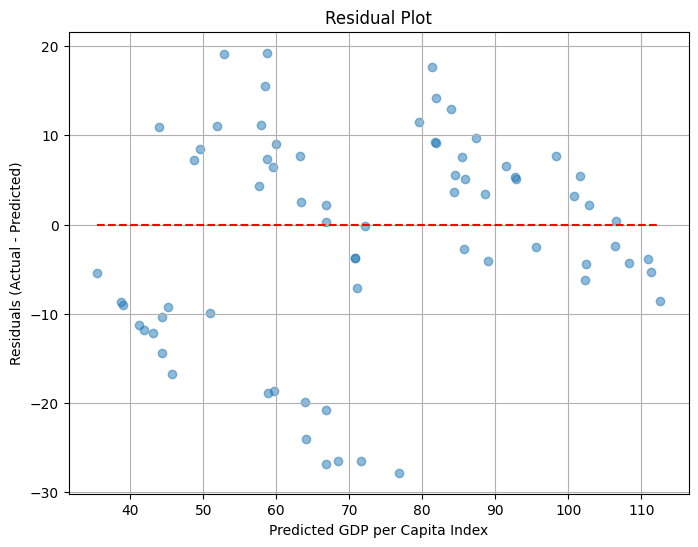

In [ ]:
# 3. Residual Plot
residuals = test_bags_labels - test_predictions

plt.figure(figsize=(8, 6))
plt.scatter(test_predictions, residuals, alpha=0.5)
plt.hlines(0, test_predictions.min(), test_predictions.max(), color='r', linestyle='--') # Horizontal line at 0
plt.xlabel("Predicted GDP per Capita Index")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.grid(True)
plt.show()

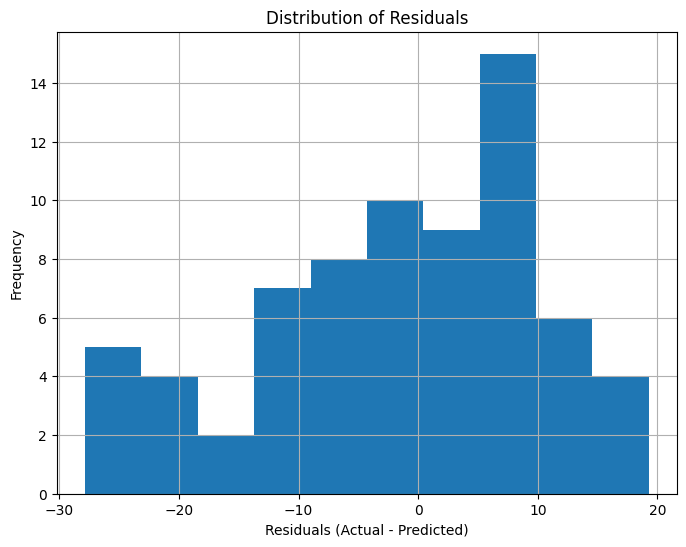

In [ ]:
# 4. Histogram of Residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=10)
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.grid(True)
plt.show()

In [ ]:
# Assuming test_bags_labels and test_predictions are available
correlation_coefficient, p_value = pearsonr(test_bags_labels.flatten(), test_predictions.flatten())

print(f"Pearson Correlation Coefficient: {correlation_coefficient:.4f}")
print(f"P-value: {p_value:.3e}")

if p_value < 0.05:
    print("Result: Statistically significant correlation between actual and predicted values.")
else:
    print("Result: No statistically significant correlation between actual and predicted values.")

Pearson Correlation Coefficient: 0.8944
P-value: 1.845e-25
Result: Statistically significant correlation between actual and predicted values.


The Pearson correlation coefficient of 0.8944 indicates a strong positive linear relationship between the actual and predicted Gross Domestic Product (GDP) per Capita Index values on your test set. This means that as the predicted GDP increases, the actual GDP also tends to increase, and this relationship is quite strong.   
The associated p-value of 1.845e-25 is extremely low (much less than the typical significance level of 0.05). This indicates that the observed strong correlation is statistically significant, meaning there is overwhelming evidence to reject the null hypothesis that there is no linear relationship between the actual and predicted values in the population. Therefore, the test results confirm that your model's predictions are highly and significantly correlated with the true GDP values.

## Save best model & Test Set

This functionality is helpful for the reproducibility of the final results.

In [ ]:
from google.colab import files
file_path = "/tmp/best_model_0.weights.h5"
files.download(file_path)

In [ ]:
# download locally from colab the test_bags and test_bags_labels to be able to reload them
import pickle
# with open('test_bags.pkl', 'wb') as f:
#    pickle.dump(test_bags, f)
with open('test_bags_labels.pkl', 'wb') as f:
    pickle.dump(test_bags_labels, f)
with open('test_predictions.pkl', 'wb') as f:
    pickle.dump(test_predictions, f)
# download locally from colab the test_bags and test_bags_labels to be able to reload them
from google.colab import files
# files.download('test_bags.pkl')
# files.download('test_bags_labels.pkl')

In [ ]:
ENSEMBLE_COUNT = 1
instance_shape = train_bags[0][0].shape
trained_models = [create_model(instance_shape, instances_count) for _ in range(ENSEMBLE_COUNT)]
# Compile model
trained_models[0].compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
# load the best_model_0.weights.h5 from drive
trained_models[0].load_weights("/content/drive/MyDrive/VIIRS/CNN/best_model_0.weights.h5")

In [ ]:
# load pickle from drive
with open('/content/drive/MyDrive/VIIRS/Regressor/test_predictions.pkl', 'rb') as f:
    test_predictions = pickle.load(f)
with open('/content/drive/MyDrive/VIIRS/Regressor/test_bags_labels.pkl', 'rb') as f:
    test_bags_labels = pickle.load(f)